In [ ]:
!pip install pytorch_pretrained_bert
!pip install pathlib

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex


Writing setup.sh


In [ ]:
!sh setup.sh

In [ ]:
from pytorch_pretrained_bert.tokenization import BertTokenizer, WordpieceTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTraining, BertPreTrainedModel, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification
from pathlib import Path
import torch
import re
from torch import Tensor
from torch.nn import BCEWithLogitsLoss
from fastai.text import Tokenizer, Vocab
import pandas as pd
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
import numpy as np
#import apex
from sklearn.model_selection import train_test_split
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from pytorch_pretrained_bert.optimization import BertAdam

In [ ]:
!pip install apex

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
import csv
csv.field_size_limit(sys.maxsize)

In [ ]:
import os
from google.colab import drive
drive.mount('drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [ ]:
DATA_PATH=Path('./data')
DATA_PATH.mkdir(exist_ok=True)

PATH=Path('./tmp')
PATH.mkdir(exist_ok=True)

CLAS_DATA_PATH=PATH/'class'
CLAS_DATA_PATH.mkdir(exist_ok=True)

model_state_dict = None

BERT_PRETRAINED_PATH = Path('./uncased_L-12_H-768_A-12/')

PYTORCH_PRETRAINED_BERT_CACHE = BERT_PRETRAINED_PATH/'cache/'
PYTORCH_PRETRAINED_BERT_CACHE.mkdir(exist_ok=True)

In [ ]:
args = {
    "train_size": 86519,
    "val_size": 21630,
    "full_data_dir": DATA_PATH,
    "data_dir": PATH,
    "task_name": "topic_multilabel",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": CLAS_DATA_PATH/'output',
    "max_seq_length": 128,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 1,
    "learning_rate": 3e-5,
    "num_train_epochs": 4.0,
    "warmup_proportion": 0.1,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "loss_scale": 128
}

In [ ]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels=2):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

## Data representation class

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [ ]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

In [ ]:
class MultiLabelTextProcessor(DataProcessor):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.labels = None
    
    
    def get_train_examples(self, data_dir, size=-1):
        filename = 'fulltext_cleaned_train.csv'
        
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, filename)))
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename), engine = 'python')
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "train")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename), engine = 'python')
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "train")
        
    def get_dev_examples(self, data_dir, size=-1):
        """See base class."""
        filename = 'fulltext_cleaned_test.csv'

        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename), error_bad_lines = False, engine = "python")
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "dev")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename), error_bad_lines = False, engine = "python")
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "dev")
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        data_df = pd.read_csv(os.path.join(data_dir, data_file_name))
#         data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
        if size == -1:
            return self._create_examples(data_df, "test", labels_available=False)
        else:
            return self._create_examples(data_df.sample(size), "test", labels_available=False)

    def get_labels(self):
        """See base class."""
        if self.labels == None:
            self.labels = list(pd.read_csv(os.path.join(self.data_dir, "classes.txt"),header=None)[0].values)
        return self.labels

    def _create_examples(self, df, set_type, labels_available=True):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, row) in enumerate(df.values):
            guid = row[0]
            text_a = row[1]
            if labels_available:
                labels = row[2:]
            else:
                labels = []
            examples.append(
                InputExample(guid=guid, text_a=text_a, labels=labels))
        return examples
        

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)

        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(float(label))
        
        #label_id = label_map[example.labels[0]]
        
        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [ ]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

#*Metric functions*

In [ ]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return np.mean(((y_pred>thresh)==y_true.byte()).float().cpu().numpy(), axis=1).sum()

def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean().item()

In [ ]:
def precision_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred_bool = y_pred>thresh
    y_pred_bool_p = y_pred_bool[y_pred_bool]
    y_true = y_true[y_pred_bool]
    if len(y_true) == 0: return 0,0
    result = np.mean((y_pred_bool_p==y_true.byte()).float().cpu().numpy(), axis=0).sum()
    return result, len(y_pred_bool_p)

In [ ]:
def recall_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred_bool = y_pred>thresh
    y_pred_bool_p = y_pred_bool[y_true.byte()]
    y_true = y_true[y_true.byte()].byte()
    if len(y_true) == 0: return 0,0
    result = np.mean((y_pred_bool_p==y_true.byte()).float().cpu().numpy(), axis=0).sum()
    return result, len(y_pred_bool_p)

# Start Evaluation


In [ ]:
processors = {
    "topic_multilabel": MultiLabelTextProcessor
}

# Setup GPU parameters

if args["local_rank"] == -1 or args["no_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
    n_gpu = torch.cuda.device_count()
#     n_gpu = 1
else:
    torch.cuda.set_device(args['local_rank'])
    device = torch.device("cuda", args['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args['local_rank'] != -1), args['fp16']))

In [ ]:
task_name = args['task_name'].lower()

if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

processor = processors[task_name](args['data_dir'])
label_list = processor.get_labels()
num_labels = len(label_list)
label_list

## Read in Model

In [ ]:
output_model_file = os.path.join(PYTORCH_PRETRAINED_BERT_CACHE, "finetuned_pytorch_model.bin")
model_state_dict = torch.load(output_model_file)
model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)
model.to(device)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(args['bert_model'], do_lower_case=args['do_lower_case'])

In [ ]:
# Eval Fn
eval_examples = processor.get_dev_examples(args['data_dir'], size=args['val_size'])
args['output_dir'].mkdir(exist_ok=True)

eval_features = convert_examples_to_features(
    eval_examples, label_list, args['max_seq_length'], tokenizer)
logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", args['eval_batch_size'])
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_ids for f in eval_features], dtype=torch.float)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args['eval_batch_size'])


In [ ]:
all_logits = None
all_labels = None
model.eval()
eval_loss, eval_accuracy, eval_recall, eval_precision = 0, 0, 0, 0
nb_eval_steps, nb_eval_examples, tp_fp, tp_fn  = 0, 0, 0, 0
for input_ids, input_mask, segment_ids, label_ids in eval_dataloader:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    tmp_eval_accuracy = accuracy_thresh(logits, label_ids)
    tmp_eval_recall, tmp_tp_fn = recall_thresh(logits, label_ids)
    tmp_eval_precision, tmp_tp_fp = precision_thresh(logits, label_ids)

    if all_logits is None:
        all_logits = logits.detach().cpu().numpy()
    else:
        all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
        
    if all_labels is None:
        all_labels = label_ids.detach().cpu().numpy()
    else:    
        all_labels = np.concatenate((all_labels, label_ids.detach().cpu().numpy()), axis=0)
    

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
    eval_recall += tmp_eval_recall
    eval_precision += tmp_eval_precision
    #print(eval_precision)
    tp_fp += tmp_tp_fp
    tp_fn += tmp_tp_fn
    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples
eval_recall = eval_recall / tp_fn
eval_precision = eval_precision / tp_fp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  


In [ ]:
#     ROC-AUC calcualation
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
recall_dict = dict()
precision_dict = dict()
accuracy_dict = dict()


for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    pred_bool = 1/(1 + np.exp(-all_logits[:, i]))
    recall_dict[i] = recall_score(all_labels[:, i], pred_bool>0.5)
    precision_dict[i] = precision_score(all_labels[:, i], pred_bool>0.5)
    accuracy_dict[i] = accuracy_score(all_labels[:, i], pred_bool>0.5)

    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'eval_recall' : eval_recall,
          'eval_precision' : eval_precision,
#               'loss': tr_loss/nb_tr_steps,
          'roc_auc': roc_auc,
          'accuracy': accuracy_dict,
          'precision': precision_dict,
          'recall': recall_dict}

output_eval_file = os.path.join(args['output_dir'], "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
#             writer.write("%s = %s\n" % (key, str(result[key])))

03/05/2022 04:15:29 - INFO - __main__ -   ***** Eval results *****
03/05/2022 04:15:29 - INFO - __main__ -     accuracy = {0: 0.9900601017105871, 1: 0.9924641701340731, 2: 0.989828941285252, 3: 0.9664355062413315, 4: 0.9611650485436893, 5: 0.9691631992602866, 6: 0.9807212205270458, 7: 0.986130374479889, 8: 0.997595931576514, 9: 0.7901063337956542, 10: 0.9729542302357836, 11: 0.9226999537679149, 12: 0.9948220064724919, 13: 0.9968562182154416, 14: 0.8809061488673139, 15: 0.9389736477115118}
03/05/2022 04:15:29 - INFO - __main__ -     eval_accuracy = 0.9581801895515488
03/05/2022 04:15:29 - INFO - __main__ -     eval_loss = 0.08919032775686939
03/05/2022 04:15:29 - INFO - __main__ -     eval_precision = 0.7027991052536122
03/05/2022 04:15:29 - INFO - __main__ -     eval_recall = 0.5481691978011739
03/05/2022 04:15:29 - INFO - __main__ -     precision = {0: 0.7109004739336493, 1: 0.39285714285714285, 2: 0.5238095238095238, 3: 0.5371900826446281, 4: 0.5055762081784386, 5: 0.5976331360946746

In [ ]:
all_labels_re = all_labels.reshape(-1)
all_logits_re = all_logits.reshape(-1)
fpr_all, tpr_all, _ = roc_curve(all_labels_re, all_logits_re)
roc_auc_all = auc(fpr_all, tpr_all)
roc_auc_all

0.9727227317529239

Text(0, 0.5, 'TPR')

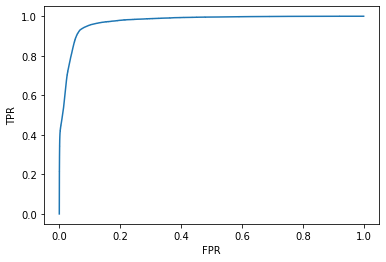

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fpr_all, tpr_all)
plt.xlabel('FPR')
plt.ylabel('TPR')

# Prediction

In [ ]:
def predict(model, path, test_filename='fulltext_cleaned_test.csv', label_ava=True):
    predict_processor = MultiLabelTextProcessor(path)
    test_examples = predict_processor.get_test_examples(path, test_filename, size=-1)
    
    # Hold input data for returning it 
    input_data = [{ 'id': input_example.guid, 'comment_text': input_example.text_a } for input_example in test_examples]

    test_features = convert_examples_to_features(
        test_examples, label_list, args['max_seq_length'], tokenizer)
    
    logger.info("***** Running prediction *****")
    logger.info("  Num examples = %d", len(test_examples))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    
    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
    
    # Run prediction for full data
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=args['eval_batch_size'])
    
    all_logits = None
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for step, batch in enumerate(tqdm(test_dataloader, desc="Prediction Iteration")):
        input_ids, input_mask, segment_ids = batch
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)

        with torch.no_grad():
            logits = model(input_ids, segment_ids, input_mask)
            logits = logits.sigmoid()

        if all_logits is None:
            all_logits = logits.detach().cpu().numpy()
        else:
            all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
            
        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    return pd.merge(pd.DataFrame(input_data), pd.DataFrame(all_logits, columns=label_list), left_index=True, right_index=True)

In [ ]:
import math

In [ ]:
result = predict(model, DATA_PATH)
bool_dic = {'id': result.id.values, 'comment_text': result.comment_text.values}
for l in label_list:
  curr = result[l].values
  curr_l = [int(x>0.5) for x in curr]
  bool_dic[l] = curr_l
result_bool = pd.DataFrame(data=bool_dic)

03/05/2022 04:20:41 - INFO - __main__ -   ***** Running prediction *****
03/05/2022 04:20:41 - INFO - __main__ -     Num examples = 21630
03/05/2022 04:20:41 - INFO - __main__ -     Batch size = 1
Prediction Iteration: 100%|██████████| 21630/21630 [04:54<00:00, 73.51it/s]


In [ ]:
result_bool.to_csv(DATA_PATH/'test_data_result.csv', index=None)

In [ ]:
result = predict(model, DATA_PATH, test_filename='inference_result_text.csv')
bool_dic = {'id': result.id.values, 'comment_text': result.comment_text.values}
for l in label_list:
  curr = result[l].values
  curr_l = [int(x>0.5) for x in curr]
  bool_dic[l] = curr_l
result_bool = pd.DataFrame(data=bool_dic)

03/05/2022 04:25:58 - INFO - __main__ -   ***** Running prediction *****
03/05/2022 04:25:58 - INFO - __main__ -     Num examples = 1453
03/05/2022 04:25:58 - INFO - __main__ -     Batch size = 1
Prediction Iteration: 100%|██████████| 1453/1453 [00:19<00:00, 74.08it/s]


In [ ]:
result_bool.to_csv(DATA_PATH/'inference_data_result.csv', index=None)